# Guia Completo: Regressão Linear Múltipla Bayesiana com PyMC

Este guia oferece um passo a passo detalhado para construir, avaliar e utilizar modelos de regressão linear múltipla sob a ótica Bayesiana. Partindo de um exemplo prático com o dataset de imóveis da Califórnia, exploraremos desde a definição de priors até a predição em novos dados, focando não apenas no "como", mas principalmente no "porquê" de cada etapa.

## Seção 1: Fundamentos da Regressão Linear Múltipla Bayesiana

A regressão linear múltipla busca modelar a relação entre uma variável dependente ($y$) e duas ou mais variáveis independentes (preditores, $\mathbf{x}$). A fórmula clássica é:

$y = \alpha + \beta_1 x_1 + \beta_2 x_2 + \dots + \beta_n x_n + \varepsilon$

Onde:
- $y$: A variável que queremos prever (ex: preço do imóvel).
- $\alpha$: O intercepto, ou o valor esperado de $y$ quando todos os $x_i$ são zero.
- $\beta_i$: Os coeficientes (ou pesos) de cada preditor. Indicam a mudança em $y$ para uma unidade de mudança em $x_i$, mantendo os outros preditores constantes.
- $\varepsilon$: O erro do modelo, que representa a variação em $y$ não explicada pelos preditores.

**A Abordagem Bayesiana:**
Diferente da abordagem frequentista, que busca um único valor "ótimo" para cada parâmetro ($\alpha, \beta_i$), a abordagem Bayesiana trata todos os parâmetros como distribuições de probabilidade.

- **Priors (Distribuições a Priori):** Nossas crenças sobre os parâmetros *antes* de vermos os dados.
- **Likelihood (Verossimilhança):** A forma como os dados são gerados, dado um conjunto de parâmetros.
- **Posterior (Distribuições a Posteriori):** A atualização das nossas crenças sobre os parâmetros *após* observarmos os dados. É a combinação dos priors com a likelihood via Teorema de Bayes.

Este processo nos entrega não apenas uma estimativa, mas uma distribuição completa de valores plausíveis para cada parâmetro, quantificando nossa incerteza.

---

## Seção 2: Estudo de Caso - Preços de Imóveis na Califórnia

Utilizaremos um dataset clássico sobre o mercado imobiliário da Califórnia. Nosso objetivo é prever o `median_house_value` com base em outros atributos.

In [1]:
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

# Carregando os dados de treinamento
df_train = pd.read_csv("sample_data/california_housing_train.csv")
df_train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0



---

## Seção 3: Construção do Primeiro Modelo

Vamos começar com um modelo simples, usando apenas `median_income` e `housing_median_age` para prever `median_house_value`.

### Como Pensar na Definição dos Priors

A escolha dos priors é uma etapa fundamental e distintiva da modelagem Bayesiana.

**1. Parâmetros de Localização (`alpha`, `beta_income`, `beta_age`):**
   - **O que fazer:** Use priors "fracamente informativos". Eles devem ser amplos o suficiente para não restringir indevidamente o modelo, mas específicos o suficiente para manter as amostragens (MCMC) em uma região plausível do espaço. Uma distribuição Normal é uma escolha padrão.
   - **Como pensar:**
     - `alpha` (intercepto): Qual seria o preço de uma casa com idade zero e renda zero? Provavelmente próximo de zero, mas com alta incerteza. Um `pm.Normal('alpha', 0, 100000)` reflete isso: centrado em zero, mas permitindo valores muito grandes (positivos ou negativos).
     - `beta_income`: Esperamos que a renda tenha um efeito positivo no preço. Quanto? Um aumento de $1 (em dezenas de milhares de dólares) na renda mediana deve aumentar o preço da casa em quanto? É difícil dizer, então usamos um prior amplo como `pm.Normal('beta_income', 0, 50000)`.
     - `beta_age`: O efeito da idade é ambíguo. Casas mais velhas podem ser mais baratas ou mais caras (charme histórico). Um prior centrado em zero é uma boa suposição inicial: `pm.Normal('beta_age', 0, 2000)`.

**2. Parâmetro de Escala (`epsilon` ou `sigma`):**
   - **O que fazer:** Este parâmetro representa o desvio padrão do erro do modelo e **deve ser estritamente positivo**. Distribuições como `HalfNormal`, `HalfCauchy` ou `Exponential` são excelentes escolhas.
   - **Como pensar:**
     - `epsilon`: Qual a magnitude esperada do nosso erro de previsão? $100? $10.000? $100.000? O `pm.HalfNormal('epsilon', 10000)` pode ser um ponto de partida mais razoável do que o `100` do rascunho, dado que os preços das casas estão na casa das centenas de milhares. No entanto, vamos manter o valor do rascunho para demonstrar o impacto dos priors na análise a seguir.
   - **O que NÃO fazer:** Nunca use uma distribuição `Normal` para um parâmetro de escala. `pm.Normal('epsilon', 100, 50)` permitiria valores negativos para o desvio padrão, o que é matematicamente impossível e quebraria o modelo.

### Código do Modelo


In [2]:
# Extraindo os dados como arrays numpy
median_income = df_train['median_income'].values
housing_median_age = df_train['housing_median_age'].values
median_house_value = df_train['median_house_value'].values

with pm.Model() as multi_linreg:
    # Priors para os parâmetros
    alpha = pm.Normal('alpha', 0, 100000)
    beta_income = pm.Normal('beta_income', 0, 50000)
    beta_age = pm.Normal('beta_age', 0, 2000)
    epsilon = pm.HalfNormal('epsilon', 100) # Desvio padrão do erro

    # Equação do modelo
    mu = alpha + beta_income * median_income + beta_age * housing_median_age

    # Likelihood: Como os dados observados são gerados
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=epsilon, observed=median_house_value)

---

## Seção 4: Análise Preditiva a Priori (Sanity Check)

Antes de ajustar o modelo, vamos verificar se as nossas escolhas de priors são sensatas. A análise preditiva a priori simula dados *apenas com base nos priors*, sem olhar para os dados observados.

**Pergunta-chave:** O modelo, com as crenças que eu inseri, é capaz de gerar dados que se parecem, ainda que vagamente, com a realidade?

In [3]:
with multi_linreg:
  prior_trace = pm.sample_prior_predictive()

Sampling: [Y_obs, alpha, beta_age, beta_income, epsilon]


Agora, vamos visualizar o resultado.

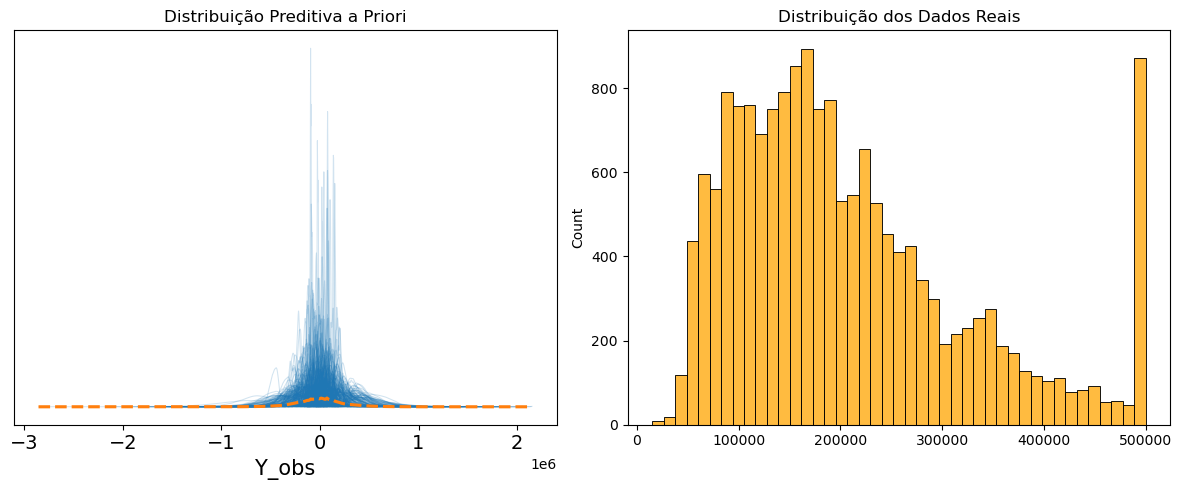

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
az.plot_ppc(prior_trace, group='prior', ax=axes[0], legend=False)
axes[0].set_title("Distribuição Preditiva a Priori")
sns.histplot(median_house_value, ax=axes[1], color='orange')
axes[1].set_title("Distribuição dos Dados Reais")
plt.tight_layout()
plt.show()

**Interpretação e Ação:**

- **O que vemos:** O gráfico da esquerda (`Y_obs`) mostra previsões com uma escala absurda (na casa dos milhões), enquanto nossos dados reais (gráfico da direita) estão concentrados entre 0 e 500.000.
- **Diagnóstico:** Nossos priors para `alpha` e `beta_income` são **excessivamente amplos (não informativos)**. Eles permitem combinações de parâmetros que geram previsões completamente fora da realidade.
- **O que fazer (Cenário Ideal):** A prática correta seria voltar e ajustar os priors. Por exemplo, poderíamos usar desvios padrão menores: `alpha = pm.Normal('alpha', 200000, 50000)` e `beta_income = pm.Normal('beta_income', 40000, 10000)`. Isso informaria ao modelo nossas expectativas de forma mais realista.
- **O que NÃO fazer:** Ignorar este aviso. Um prior ruim pode levar a uma convergência lenta do MCMC ou a resultados enviesados, mesmo com muitos dados.

Para fins didáticos, seguiremos com os priors originais para ver como os dados os "corrigem", mas lembre-se que o ideal é começar com priors mais sensatos.



## Seção 5: Inferência e Análise Preditiva a Posteriori

Agora, vamos ajustar o modelo aos dados e obter as distribuições a posteriori.

In [5]:
with multi_linreg:
  trace = pm.sample()

 Progress                    Draws   Divergences   Step size   Grad evals   Sampling Speed   Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━━━   2000    0             0.25        15           50.37 draws/s    0:00:39   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━   2000    0             0.37        15           44.69 draws/s    0:00:44   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━   2000    0             0.34        15           43.31 draws/s    0:00:46   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━   2000    0             0.35        15           42.25 draws/s    0:00:47   0:00:00

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.


O `trace` contém as amostras da distribuição posterior de cada parâmetro. Vamos verificar o resumo:

In [6]:
pm.summary(trace, var_names=['alpha', 'beta_income', 'beta_age', 'epsilon'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-11106.587,815.683,-12637.391,-9568.834,18.645,14.249,1912.0,2048.0,1.0
beta_income,43387.170,125.856,43159.152,43634.494,2.738,2.233,2122.0,2296.0,1.0
beta_age,1745.897,18.886,1707.861,1778.933,0.397,0.315,2267.0,2390.0,1.0
epsilon,31185.089,46.858,31098.075,31272.836,0.821,0.832,3264.0,2469.0,1.0


Isso nos dará a média, desvio padrão e intervalos de credibilidade (HDI) para cada parâmetro.

### Análise Preditiva a Posteriori

Agora, a pergunta é outra: **O modelo, *depois de aprender com os dados*, consegue gerar simulações que se parecem com os dados que ele viu?**

Sampling ... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:02

<Axes: xlabel='Y_obs'>

/nix/store/9r5c82ch6xg9j1wwbvz8sf1sv87zk3j8-python3.12-ipython-9.2.0/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/nix/store/9r5c82ch6xg9j1wwbvz8sf1sv87zk3j8-python3.12-ipython-9.2.0/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


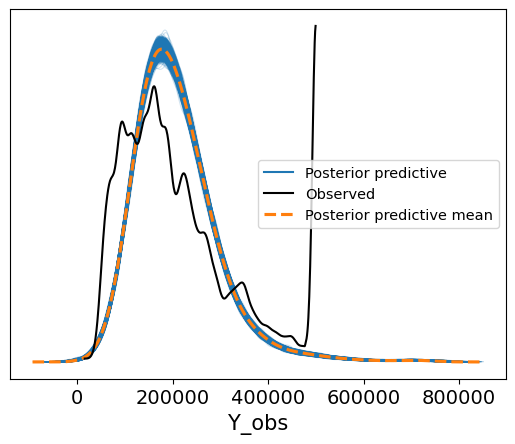

In [7]:
with multi_linreg:
    trace_post = pm.sample_posterior_predictive(trace)

az.plot_ppc(trace_post, group='posterior')

**Interpretação:**

- **O que vemos:** A curva preta (dados observados) e as curvas azuis (simulações do modelo) estão muito mais alinhadas do que na análise a priori. O modelo aprendeu com os dados.
- **Diagnóstico:** O ajuste melhorou drasticamente. No entanto, o modelo não consegue capturar o pico acentuado nos dados observados em torno de 500.000 e a cauda longa à direita.
- **Conclusão:** Nosso modelo é um começo, mas é simplista demais. Precisamos de mais informações ou de uma estrutura de modelo diferente.

## Seção 6: Iteração e Aprimoramento do Modelo

A modelagem é um processo iterativo. Vamos tentar duas melhorias.

### Iteração 1: Adicionando um Novo Preditor (`population`)

**Como pensar:** O preço das casas pode ser influenciado pela densidade populacional. Áreas mais populosas podem ter preços diferentes. Vamos testar essa hipótese.

Sampling ... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:05

<Axes: xlabel='Y_obs'>

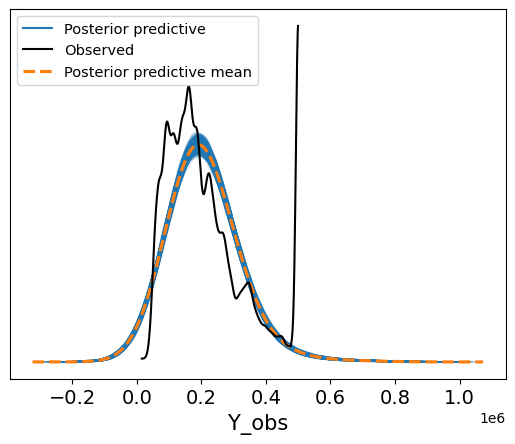

In [8]:
population = df_train['population'].values

with pm.Model() as multi_linreg_pop:
    # Mesmos priors de antes...
    alpha = pm.Normal('alpha', 0, 100000)
    beta_income = pm.Normal('beta_income', 0, 50000)
    beta_age = pm.Normal('beta_age', 0, 2000)
    # Novo prior para o coeficiente da população
    beta_pop = pm.Normal('beta_pop', 0, 5) # Prior mais justo, pois a escala da população é grande
    sigma = pm.HalfNormal('sigma', 50000) # Aumentando o prior do erro

    # Nova equação
    mu = alpha + beta_income * median_income + beta_age * housing_median_age + beta_pop * population

    # Likelihood
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=median_house_value)

with multi_linreg_pop:
  trace_pop = pm.sample()
  trace_post_pop = pm.sample_posterior_predictive(trace_pop)
# az.plot_ppc(trace_post, group='posterior', kind='cumulative', ax=axes[0])
# az.plot_ppc(trace_post, group='posterior', ax=axes[1])
az.plot_ppc(trace_post_pop, group='posterior')

**Resultado:** O ajuste melhora! O modelo agora captura melhor a forma geral da distribuição dos dados.

### Iteração 2: Construindo um Modelo Robusto (com Distribuição T-Student)

**Como pensar:** A distribuição Normal é muito sensível a outliers. Se nossos dados possuem valores extremos (casas muito baratas ou muito caras que fogem do padrão), eles podem "puxar" a linha de regressão indevidamente. A distribuição T-Student tem "caudas mais pesadas", o que a torna mais robusta a outliers.

**O que fazer:** Simplesmente troque a likelihood `pm.Normal` por `pm.StudentT`. A `StudentT` tem um parâmetro extra, `nu` (graus de liberdade), que controla a "robustez". Vamos colocar um prior sobre `nu` para que o modelo aprenda o quão robusto ele precisa ser.

Sampling ... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:07

<Axes: xlabel='Y_obs'>

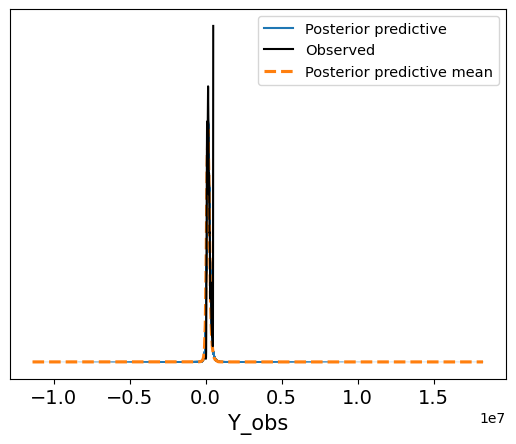

In [9]:
with pm.Model() as multi_linreg_pop_t:
    # Mesmos priors para os coeficientes
    alpha = pm.Normal('alpha', 0, 100000)
    beta_income = pm.Normal('beta_income', 0, 50000)
    beta_age = pm.Normal('beta_age', 0, 2000)
    beta_pop = pm.Normal('beta_pop', 0, 5)
    sigma = pm.HalfNormal('sigma', 50000)

    # Prior para os graus de liberdade
    nu = pm.Exponential("nu", 1/29) + 1 # Recomendação comum para nu > 1

    # Equação
    mu = alpha + beta_income * median_income + beta_age * housing_median_age + beta_pop * population

    # Likelihood T-Student
    Y_obs = pm.StudentT('Y_obs', nu=nu, mu=mu, sigma=sigma, observed=median_house_value)

with multi_linreg_pop_t:
  trace_p_t = pm.sample()
  trace_post_t = pm.sample_posterior_predictive(trace_p_t)

az.plot_ppc(trace_post_t, group='posterior')

O `pm.summary` para este modelo mostrará um valor médio baixo para `nu`, confirmando que os dados têm caudas pesadas e que a robustez foi uma boa escolha.

## Seção 7: Comparação Formal de Modelos

Temos três modelos. Qual é o melhor? "Olhar o gráfico" é subjetivo. Precisamos de uma métrica formal.

**Como pensar:** Queremos um modelo que preveja bem dados *futuros*, não apenas os dados que já vimos. Métricas como **LOO-CV (Leave-One-Out Cross-Validation)** e **WAIC** estimam a performance preditiva fora da amostra. Elas recompensam o bom ajuste e penalizam a complexidade excessiva.

**O que fazer:** Use a função `az.compare` do ArviZ.

Computing ... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00

<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

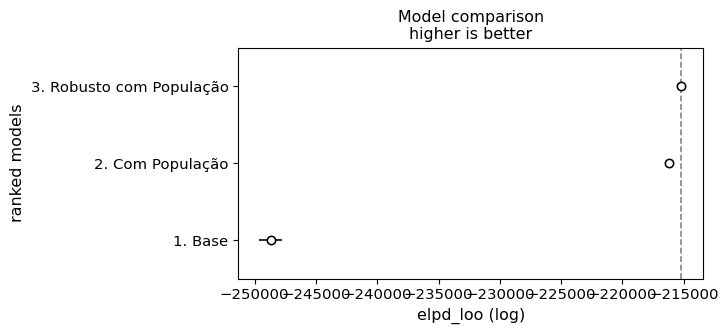

In [10]:
# Primeiro, precisamos calcular a log-likelihood para cada modelo
with multi_linreg:
    pm.compute_log_likelihood(trace)
with multi_linreg_pop:
    pm.compute_log_likelihood(trace_pop)
with multi_linreg_pop_t:
    pm.compute_log_likelihood(trace_p_t)

# Comparar os modelos
model_compare = az.compare({
    "1. Base": trace,
    "2. Com População": trace_pop,
    "3. Robusto com População": trace_p_t,
})

az.plot_compare(model_compare, insample_dev=False)

**Interpretação:**

- O gráfico `az.plot_compare` ordena os modelos do melhor (topo) para o pior (baseado no ELPD LOO).
- A tabela `model_compare` mostra os valores numéricos. O modelo no topo é a nossa referência. Os outros são comparados a ele (`elpd_diff`).
- **Resultado esperado:** O modelo "Robusto com População" será classificado como o melhor, pois ele captura melhor a estrutura dos dados (graças à variável `population`) e lida melhor com outliers (graças à likelihood T-Student).

## Seção 8: Previsão em Novos Dados (Conjunto de Teste)

O objetivo final é usar nosso modelo vencedor para fazer previsões em dados que ele nunca viu.

**O que fazer:** A maneira mais eficiente em PyMC é usar `pm.MutableData`. Isso nos permite construir o modelo uma vez e depois "alimentá-lo" com novos dados para predição, sem a necessidade de recompilar ou re-treinar.

In [12]:
# Carregar dados de teste
df_test = pd.read_csv('sample_data/california_housing_test.csv')
population_test = df_test['population'].values
median_income_test = df_test['median_income'].values
housing_median_age_test = df_test['housing_median_age'].values
median_house_value_test = df_test['median_house_value'].values

# Recriando o modelo vencedor com pm.MutableData para TODAS as variáveis de dados
with pm.Model() as final_model:
    # Placeholders para os dados
    pop_data = pm.MutableData('pop_data', population)
    income_data = pm.MutableData('income_data', median_income)
    age_data = pm.MutableData('age_data', housing_median_age)
    
    y_data = pm.MutableData('y_data', median_house_value)

    # Priors (usando os do modelo T-Student)
    alpha = pm.Normal('alpha', 0, 100000)
    beta_income = pm.Normal('beta_income', 0, 50000)
    beta_age = pm.Normal('beta_age', 0, 2000)
    beta_pop = pm.Normal('beta_pop', 0, 5)
    sigma = pm.HalfNormal('sigma', 50000)
    nu = pm.Exponential("nu", 1/29) + 1

    mu = alpha + beta_income * income_data + beta_age * age_data + beta_pop * pop_data

    # Use o placeholder mutável nos dados observados
    Y_obs = pm.StudentT('Y_obs', nu=nu, mu=mu, sigma=sigma, observed=y_data)

# Treinar o modelo (exatamente como antes)
with final_model:
    final_trace = pm.sample()

# Agora, trocamos os dados pelos dados de teste
with final_model:
    pm.set_data({
        "pop_data": population_test,
        "income_data": median_income_test,
        "age_data": housing_median_age_test,
        "y_data": median_house_value_test # Atualiza o y para manter a consistência de forma
    })

    # Gerar previsões para o conjunto de teste
    # Agora isso funcionará, pois todas as formas são consistentes (3.000)
    ppc_test = pm.sample_posterior_predictive(final_trace)

print("Previsões geradas com sucesso!")
print(ppc_test.posterior_predictive)

Sampling ... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:03

Previsões geradas com sucesso!
<xarray.Dataset> Size: 96MB
Dimensions:      (chain: 4, draw: 1000, Y_obs_dim_0: 3000)
Coordinates:
  * chain        (chain) int64 32B 0 1 2 3
  * draw         (draw) int64 8kB 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * Y_obs_dim_0  (Y_obs_dim_0) int64 24kB 0 1 2 3 4 ... 2995 2996 2997 2998 2999
Data variables:
    Y_obs        (chain, draw, Y_obs_dim_0) float64 96MB 4.162e+05 ... 4.546e+05
Attributes:
    created_at:                 2025-10-09T02:55:48.697066+00:00
    arviz_version:              0.21.0
    inference_library:          pymc
    inference_library_version:  5.21.2


### Avaliando as Previsões

A `ppc_test` contém uma distribuição completa de previsões para cada ponto de dado no conjunto de teste. Para comparar com métricas clássicas como MAE e RMSE, precisamos de uma estimativa pontual (por exemplo, a média da distribuição preditiva).

In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Calculando a média das previsões
predicted_values = ppc_test.posterior_predictive["Y_obs"].mean(axis=(0, 1)).to_numpy()

# Comparando com os valores reais do conjunto de teste
mae = mean_absolute_error(median_house_value_test, predicted_values)

# 1. Calcule o MSE
# 2. Tire a raiz quadrada com np.sqrt()
mse = mean_squared_error(median_house_value_test, predicted_values)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


Mean Absolute Error (MAE): 58736.28
Root Mean Squared Error (RMSE): 82156.28


Essas métricas nos dão uma ideia da magnitude média do erro de previsão do nosso modelo em dólares.

## Seção 9: Dicas, Alternativas e Próximos Passos

1.  **Padronização de Variáveis:**
    - **O que fazer:** Antes de modelar, padronize seus preditores (por exemplo, usando `StandardScaler` do Scikit-learn).
    - **Por que:** Isso coloca todas as variáveis na mesma escala. Os benefícios são enormes:
        - O sampler MCMC converge muito mais rápido.
        - A definição de priors se torna mais fácil, pois podemos usar o mesmo prior (ex: `pm.Normal(0, 1)`) para todos os coeficientes $\beta$.
        - A interpretação dos coeficientes se torna "para cada aumento de 1 desvio padrão no preditor X...".

2.  **Priors Mais Informativos:**
    - Se você tem conhecimento de domínio, use-o! Por exemplo, se você sabe que o coeficiente de renda deve estar entre $20.000 e $60.000, um prior como `pm.Normal(40000, 10000)` é muito melhor do que um prior vago centrado em zero.

3.  **Diagnósticos do MCMC:**
    - **O que fazer:** Sempre inspecione os gráficos de traço (`az.plot_trace(trace)`). Eles ajudam a diagnosticar problemas de convergência do amostrador. Procure por gráficos que pareçam "ruído branco" e distribuições suaves.
    - **O que NÃO fazer:** Confiar cegamente nos resultados sem verificar a convergência.

4.  **Modelos Alternativos:**
    - **Interações:** O efeito da renda no preço pode depender da idade da casa? Adicione um termo de interação: `beta_income_age * median_income * housing_median_age`.
    - **Efeitos Não-Lineares:** A relação pode não ser linear. Modelos como GAMs (Generalized Additive Models) podem capturar essas relações.
    - **Modelos Hierárquicos:** Se os dados tivessem uma estrutura de agrupamento (ex: casas em diferentes cidades), um modelo hierárquico poderia estimar efeitos específicos para cada cidade, ao mesmo tempo que compartilha informações entre elas.

## Conclusão

Este guia demonstrou o fluxo de trabalho completo da modelagem Bayesiana: começar com um modelo simples, validá-lo com checagens preditivas (a priori e a posteriori), iterar adicionando complexidade de forma justificada, comparar modelos formalmente e, finalmente, usar o melhor modelo para fazer previsões em novos dados. A abordagem Bayesiana fornece uma estrutura rica e flexível que não apenas gera previsões, mas também quantifica a incerteza em cada etapa do processo.